
# Interest Rates Derivatives

---
Ouijdane ABCHIR, April 2024.
---
About this notebook : 
---

- **Summary** : The goal of this notebook is to price some interest rates derivatives : Swaps, Caplets and Swaptions

In order to complete this task, we will do the following steps :
- Extract ZC from a Market Curve
- Use Vasicek Model for the instantaneous interest rate
- Calibration of the Vasicek Model
- IR derivatives pricing with Monte-Carlo

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss
from math import exp, sqrt, log
from scipy.optimize import root

## Load the IR market curve

In [384]:
data = pd.read_excel('IRMarketCurve.xlsx', sheet_name="ZC Extract and Swap price")
IRcurve = data.iloc[:,:5]
IRcurve = IRcurve.drop(columns = ['Type', 'ZC bond values', 'ZC bond rates'])

display(IRcurve.head(8))

,Maturity (in years),Rate
0,0.003968,0.01430
1,0.250000,0.01690
2,0.500000,0.01840
3,1.000000,0.01908
4,2.000000,0.02091
5,3.000000,0.02184
6,4.000000,0.02227
7,5.000000,0.02261


## Extracting ZC from a Market Curve

To extract ZC bond values from market curves, we use the following formulas :
- For rates with maturity <= 1 :
$$ZC(0,T) = \frac{1}{1 + \delta(0,T) \times Rate(0,T)}$$
Where $\delta(0,T) = \frac{T}{360}$ is the year fraction between time 0 and maturity T.

- For swap rates ($SR$) with maturity > 1 :
$$ZC(0,N) = \frac{1 - SR_N \times \sum_{i=1}^{N-1} \delta(i-1,i) \times ZC(0,i)}{1 + SR_N \times \delta(N-1,N)}$$

To extract ZC bond rates from ZC bond values, we use the following formulas :
- For rates with maturity <= 1 :
$$R(0,T) = \frac{1}{T} (\frac{1}{ZC(0,T)} - 1)$$

- For rates with maturity > 1 :
$$R(0,T) = ZC(0,T)^{-1/T} - 1$$

In [385]:
def extractZCCurve(IRCurve):

    IRCurve = IRCurve.copy()

    # ZC values :
    IRCurve['ZC values'] = np.zeros(len(IRCurve))

    IRCurve.loc[IRCurve['Maturity (in years)'] <= 1, 'ZC values'] = 1 / (1 + IRCurve.loc[IRCurve['Maturity (in years)'] <= 1, 'Maturity (in years)'] * IRCurve.loc[IRCurve['Maturity (in years)'] <= 1, 'Rate'])

    n = IRCurve[IRCurve['Maturity (in years)'] >= 1 ].index[0]
    for i in range(n+1, len(IRCurve)) :
        IRCurve.loc[i, 'ZC values'] = (1 - IRCurve.loc[i, 'Rate'] * (IRCurve.loc[n:i, 'ZC values']).sum()) / (1 + IRCurve.loc[i, 'Rate'])
    
    # ZC rates :
    IRCurve.loc[IRCurve['Maturity (in years)'] <= 1, 'ZC rates'] = (1/IRCurve.loc[IRCurve['Maturity (in years)'] <= 1, 'Maturity (in years)']) * (1/IRCurve.loc[IRCurve['Maturity (in years)'] <= 1, 'ZC values'] - 1)
    IRCurve.loc[IRCurve['Maturity (in years)'] > 1, 'ZC rates'] = IRCurve.loc[IRCurve['Maturity (in years)'] > 1, 'ZC values']**(-1/IRCurve.loc[IRCurve['Maturity (in years)'] > 1, 'Maturity (in years)']) - 1

    return IRCurve

ZCCurve = extractZCCurve(IRcurve)

ZCCurve.head(10)

,Maturity (in years),Rate,ZC values,ZC rates
0,0.003968,0.01430,0.999943,0.014300
1,0.250000,0.01690,0.995793,0.016900
2,0.500000,0.01840,0.990884,0.018400
3,1.000000,0.01908,0.981277,0.019080
4,2.000000,0.02091,0.959420,0.020929
5,3.000000,0.02184,0.937148,0.021874
6,4.000000,0.02227,0.915522,0.022311
7,5.000000,0.02261,0.894018,0.022659
8,6.000000,0.02295,0.872403,0.023011
9,7.000000,0.02332,0.850512,0.023401


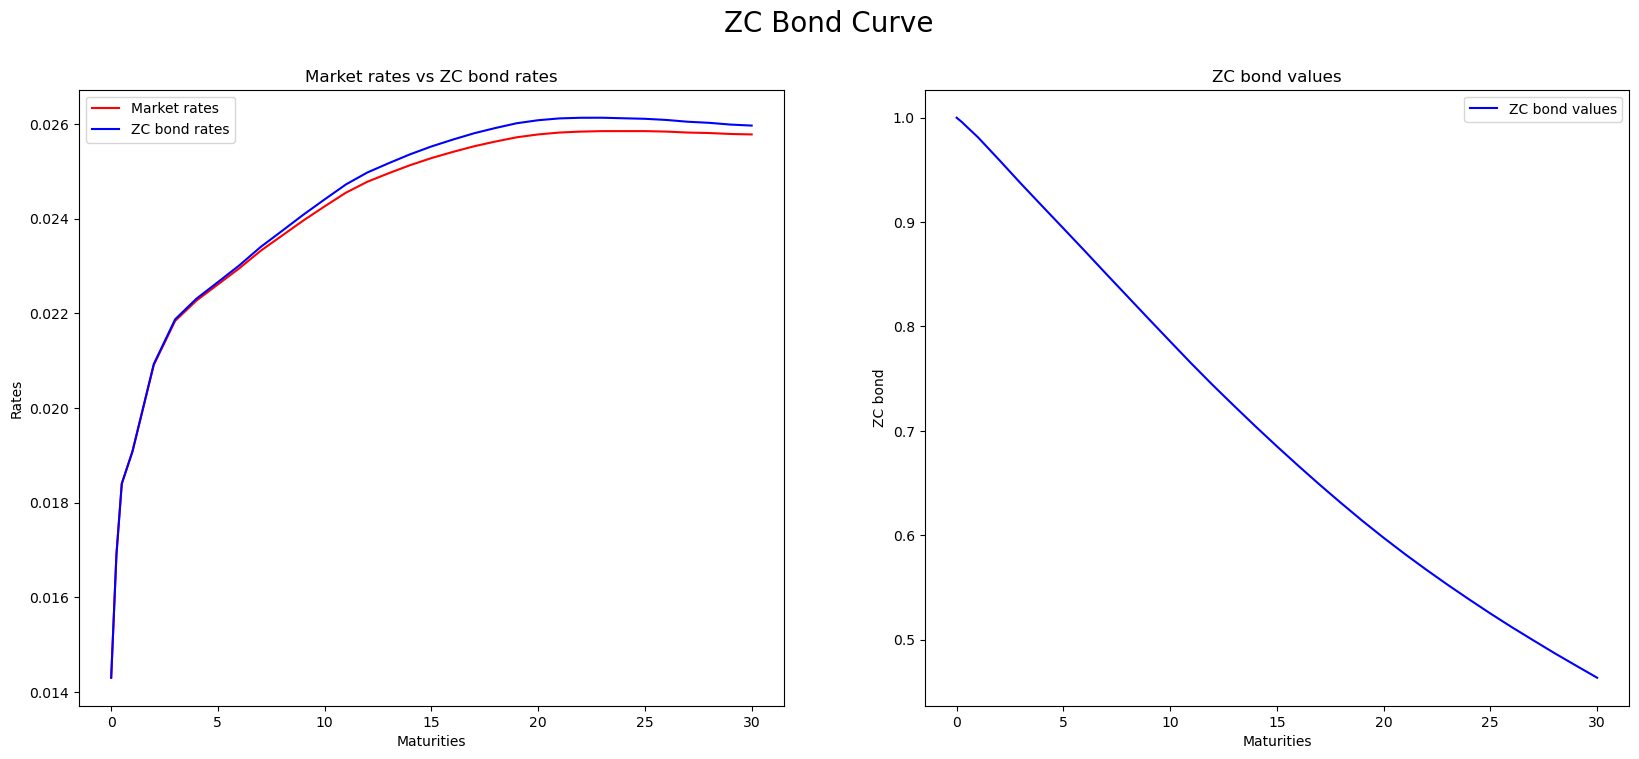

In [386]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('ZC Bond Curve', fontsize=20)

axs[0].plot(ZCCurve['Maturity (in years)'], ZCCurve['Rate'], color = 'r', label = 'Market rates')
axs[0].plot(ZCCurve['Maturity (in years)'], ZCCurve['ZC rates'], color = 'b', label = 'ZC bond rates')
axs[0].set_xlabel("Maturities")
axs[0].set_ylabel("Rates")
axs[0].set_title("Market rates vs ZC bond rates")
axs[0].legend()

axs[1].plot(ZCCurve['Maturity (in years)'], ZCCurve['ZC values'], color = 'b', label = 'ZC bond values')
axs[1].set_xlabel("Maturities")
axs[1].set_ylabel("ZC bond")
axs[1].set_title("ZC bond values")
axs[1].legend()

In this section, we will price a swap with the following parameters :
- Maturity $T_N = 10$ years.
- Fixed rate is equal to a swap rate with the same maturity, ie. $K = SR(T = 10)$.
- Notional $N = 1$.
- The frequency of the fixed leg is 1 year.

Reminder, the swap's price is given by :
$$ SWAP_t = N \times [1 - (\sum_{i=1}^{N} K \times ZC(t, T_i) +  ZC(t, T_N))] $$

In [387]:
def SwapPrice(N, T, FixedLeg, n) : 
    n0 = ZCCurve[ZCCurve['Maturity (in years)'] == 1].index[0]
    Swap = N * (1 - (FixedLeg * ZCCurve.loc[n0:n, 'ZC values'].sum() + ZCCurve.loc[n, 'ZC values']))
    return Swap

N = 1_000_000
T = 10
n = ZCCurve[ZCCurve['Maturity (in years)'] == T].index[0]  # the index of the maturity
FixedLeg = ZCCurve.loc[n, 'Rate']

Swap1 = SwapPrice(N, T, FixedLeg, n)

print('The swap\'s price is : ',  Swap1)
print('Since we are using the swap rate with the same matyrity as a fixed leg, the price should be equal to zero.')

The swap's price is :  0.0
Since we are using the swap rate with the same matyrity as a fixed leg, the price should be equal to zero.


In this section, we will price a swap with the following parameters :
- Maturity $T_N = 20$ years.
- Fixed rate is equal to a swap rate with the same maturity + 50 bps, ie. $K = SR(T = 20) + 50 bps $.
- Notional $N = 1$.
- The frequency of the fixed leg is 1 year.

In [388]:
N = 1_000_000
T = 20
n = ZCCurve[ZCCurve['Maturity (in years)'] == T].index[0]  # the index of the maturity
FixedLeg = ZCCurve.loc[n, 'Rate'] + 0.005

Swap2 =  SwapPrice(N, T, FixedLeg, n)

print('The swap\'s price is : ', Swap2)

The swap's price is :  -78054.99445682562


Now we will compute the sensitivities of the 2 swaps defined above with respect to parallel shift of the IR Curve (1% shift).

In [389]:
IRcurve_shifted = IRcurve.copy()
IRcurve_shifted['Rate'] = IRcurve_shifted['Rate'] + 0.01

ZCCurve_shifted = extractZCCurve(IRcurve_shifted)

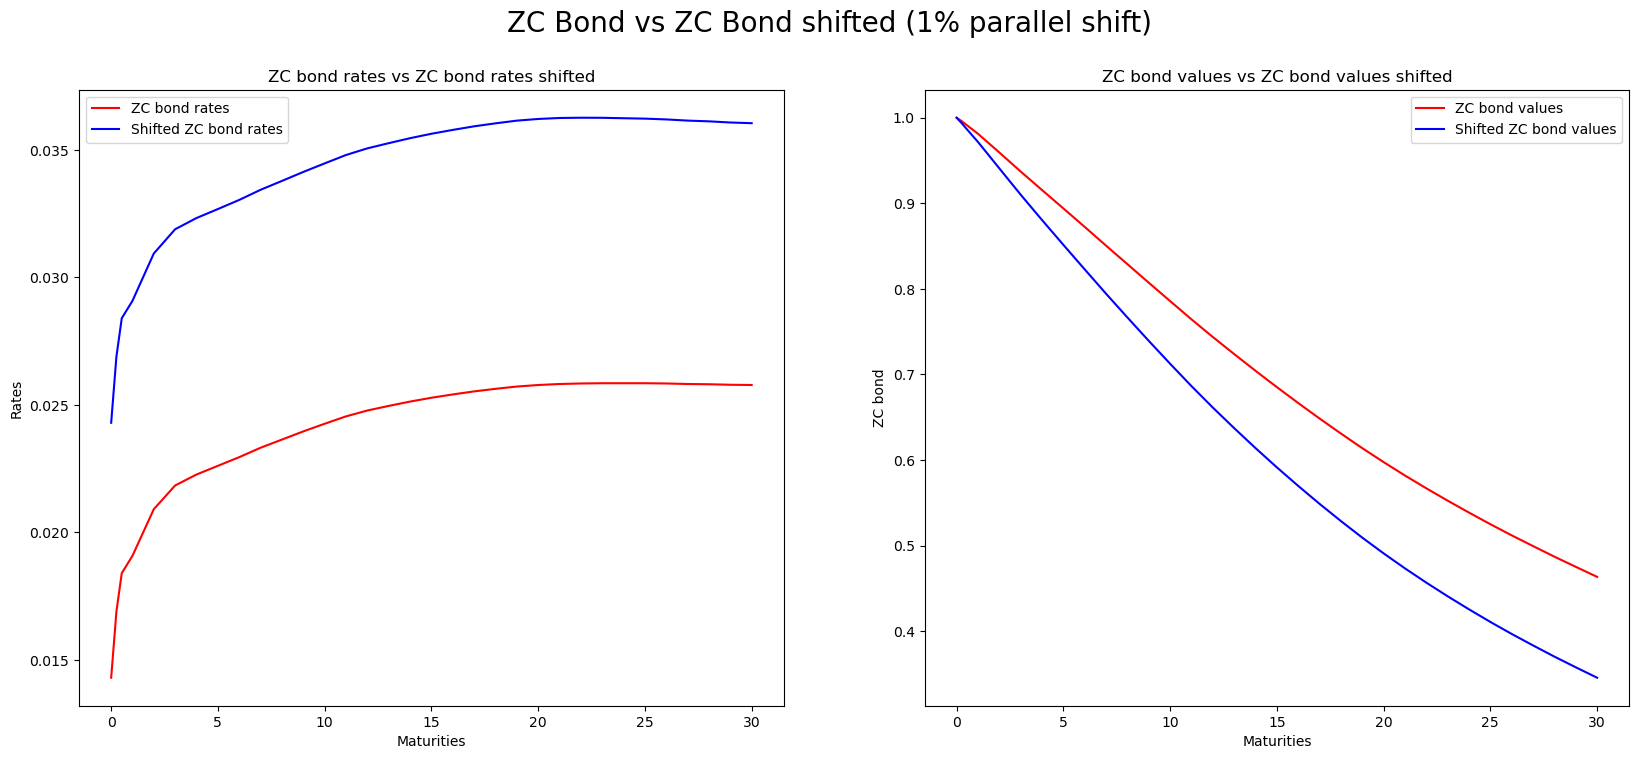

In [390]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('ZC Bond vs ZC Bond shifted (1% parallel shift)', fontsize=20)

axs[0].plot(ZCCurve['Maturity (in years)'], ZCCurve['Rate'], color = 'r', label = 'ZC bond rates')
axs[0].plot(ZCCurve_shifted['Maturity (in years)'], ZCCurve_shifted['ZC rates'], color = 'b', label = 'Shifted ZC bond rates')
axs[0].set_xlabel("Maturities")
axs[0].set_ylabel("Rates")
axs[0].set_title("ZC bond rates vs ZC bond rates shifted")
axs[0].legend()

axs[1].plot(ZCCurve['Maturity (in years)'], ZCCurve['ZC values'], color = 'r', label = 'ZC bond values')
axs[1].plot(ZCCurve_shifted['Maturity (in years)'], ZCCurve_shifted['ZC values'], color = 'b', label = 'Shifted ZC bond values')
axs[1].set_xlabel("Maturities")
axs[1].set_ylabel("ZC bond")
axs[1].set_title("ZC bond values vs ZC bond values shifted")
axs[1].legend()

In [391]:
# Sensitivity of the first swap

N = 1_000_000
T = 10
n = ZCCurve_shifted[ZCCurve_shifted['Maturity (in years)'] == T].index[0]  # the index of the maturity
FixedLeg = ZCCurve_shifted.loc[n, 'Rate']

Swap1_shifted = SwapPrice(N, T, FixedLeg, n)

delta1 = (Swap1_shifted - Swap1) / 0.01

print('The swap\'s price is : ',  Swap1_shifted)
print('The sesitivity is : ',  delta1)

The swap's price is :  -88321.07781582965
The sesitivity is :  -8832107.781582965


In [392]:
# Sensitivity of the second swap

N = 1_000_000
T = 20
n = ZCCurve_shifted[ZCCurve_shifted['Maturity (in years)'] == T].index[0]  # the index of the maturity
FixedLeg = ZCCurve_shifted.loc[n, 'Rate'] + 0.005

Swap2_shifted =  SwapPrice(N, T, FixedLeg, n)

delta2 = (Swap2_shifted - Swap2) / 0.01

print('The swap\'s price is : ',  Swap2_shifted)
print('The sesitivity is : ',  delta2)

The swap's price is :  -234164.98337047643
The sesitivity is :  -15610998.89136508


## Vasicek Model

In the Vasicek model, the dynamic of the instantaneous interest rate rt under the risk-neutral probability is given by the SDE :
$$ dr_t = a (\theta - r_t) dt + \sigma dW_t  $$
$$ r_0 = r $$

Where :
- $a$ is the mean reversion speed.
- $\theta$ is the long term expectation of interest rate. 
- $\sigma$ is the volatility.
- $r$ is the initial instantaneous rate.
- $W$ is a Brownian Motion

In this model, the closed-form formula for Zero-Coupon is given by :
$$ ZC(t,T) = A(t,T) \times \exp(-B(t,T) \times r_t)$$

Where :
$$ A(t,T) =\exp((\theta - \frac{\sigma ²}{2a²})(B(t,T)-T+t) - \frac{\sigma ²}{4a} B(t,T)²) $$
$$ B(t,T) = \frac{1}{a} (1 - \exp(-a(T-t)))$$

Now, we will implement the ZC bond formula :

In [393]:
def VasicekZCPrice(t, T, a, theta, sigma, r_t):
    B = (1/a) * (1 - exp(-a*(T-t)))
    A = exp((theta - ((sigma*sigma)/(2*a*a))) * (B - T + t) - ((sigma*sigma)/(4*a)) * B * B)
    ZC = A * exp(-B * r_t)
    return ZC

In [394]:
t, T = 0, 10

a , theta, sigma, r = 0.5, 0.04, 0.015, 0.02

print('The price of this ZC bond is : ', VasicekZCPrice(t, T, a, theta, sigma, r))

The price of this ZC bond is :  0.6996973392033585


In this section, we will compute the Zero-Coupon value using Monte Carlo methods.\
Reminder, in the Vasicek model the intreset rate is given by :
$$ r_t = r_0 \exp(-at) + \theta (1 - \exp(-at)) + \sigma \int_{0}^{t} \exp(-a(t-u)) dW_u $$

The price of the ZC bond is given by :
$$ ZC(t, T) = \mathbb{E}_{t}^{Q}[\exp(-\int_{t}^{T} r_u du)] $$

In [395]:
def VasicekZCPriceByMC(t ,T ,a ,theta , sigma, r_t, nbSimul, nbSteps):
    
    dt = (T-t) / nbSteps
    sqrt_dt = sqrt(dt)
    std = sigma * sqrt( (1 - exp(-2*a*dt)) / (2*a) )
    myMCestimate = 0

    for i in range(nbSimul):
        spotRate = r_t
        integralSpotRate = 0
        for j in range(nbSteps):
            integralSpotRate += spotRate #to compute the integral of the short rate process
            spotRate = spotRate * exp(-a*dt) + theta * (1 - exp(-a*dt)) + std * gauss(0.0,1.0)
        integralSpotRate *= dt
        myMCestimate += exp(-integralSpotRate)
    myMCestimate /= nbSimul
    return myMCestimate

In [396]:
t, T = 0, 10
a , theta, sigma, r = 0.5, 0.04, 0.015, 0.02

nbSimul, nbSteps = 10000, 100

print('Using MC method, The price of this ZC bond is : ', VasicekZCPriceByMC(t ,T ,a ,theta , sigma, r, nbSimul, nbSteps))  

Using MC method, The price of this ZC bond is :  0.7012032847780021


Now we will compare ZC extracted from Market and the value obtained from the Vasicek model for all the different maturities

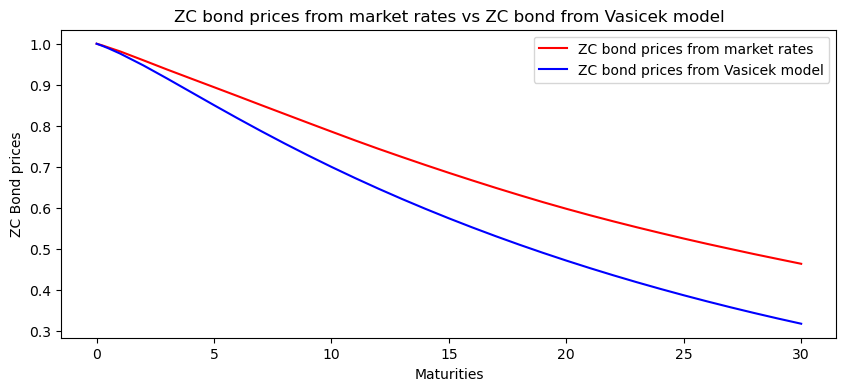

In [397]:
ZC_Market_Vasicek = ZCCurve[['Maturity (in years)', 'ZC values']].copy()
ZC_Market_Vasicek['VasicekZC'] = ZC_Market_Vasicek['Maturity (in years)'].apply(lambda T : VasicekZCPrice(t, T, a, theta, sigma, r))

plt.figure(figsize=(10, 4))

plt.plot(ZC_Market_Vasicek['Maturity (in years)'], ZC_Market_Vasicek['ZC values'], color = 'r', label = 'ZC bond prices from market rates')
plt.plot(ZC_Market_Vasicek['Maturity (in years)'], ZC_Market_Vasicek['VasicekZC'], color = 'b', label = 'ZC bond prices from Vasicek model')
plt.xlabel("Maturities")
plt.ylabel("ZC Bond prices")
plt.title("ZC bond prices from market rates vs ZC bond from Vasicek model")
plt.legend()

In this part, we will price a caplet with the following characteristics :
- Notional N = 1 000 000.
- Fixed leg K = 0,02.
- Floating rate Libor rate observed at T = 1 and paid at S = 2 : L(T, S)

Reminder :\
The payoff of a caplet is given by : $payoff = N \times \delta(T,S) \times (L(T,S) - K)_{+}$
The caplet price is given by :
$$ caplet_t = N \times \delta(T,S) \times \mathbb{E}_{t}^{Q}[\exp(-\int_{t}^{S} r_u du) \times (L(T,S) - K)_{+}]$$

The Libor rate is given by :
$$ L(T,S) = \frac{1}{\delta(T,S)} (\frac{1}{ZC(T,S)} - 1)$$

The caplet price can be therefore also derived as :
$$ caplet_t = N \times (1 + \delta(T,S) \times K) \times \mathbb{E}_{t}^{Q}[\exp(-\int_{t}^{T} r_u du) \times (\frac{1}{1 + \delta(T,S) \times K} - ZC(T,S))_{+}]$$

In [398]:
def VasicekCapletPriceByMC(t, T, S, strike, a, theta, sigma, rt, nbSimul, nbSteps):
    dt = (T-t) / nbSteps
    sqrt_dt = sqrt(dt)
    std = sigma * sqrt( (1 - exp(-2*a*dt)) / (2*a) )
    myMCestimate = 0
    for i in range(nbSimul):
        spotRate = rt
        integralSpotRate = 0
        for j in range(nbSteps):
            integralSpotRate += spotRate #to compute the integral of the short rate process
            spotRate = spotRate * exp(-a*dt) + theta * (1 - exp(-a*dt)) + std * gauss(0.0,1.0)
        integralSpotRate *= dt
        ZC = VasicekZCPrice(T, S, a, theta, sigma, spotRate)
        myMCestimate += N * (1 + strike * (S-T)) * exp(-integralSpotRate) * max((1/(1 + strike * (S-T))) - ZC, 0)
    myMCestimate /= nbSimul
    return myMCestimate

In [399]:
N = 1_000_000

t, T, S = 0, 1, 2

strike = 0.02

a , theta, sigma, r = 0.5, 0.04, 0.015, 0.02

nbSimul, nbSteps = 10000, 100

print('The caplet price is : ', VasicekCapletPriceByMC(t,T,S,strike,a,theta,sigma,r,nbSimul,nbSteps))

The caplet price is :  10799.1088011288


Model Calibration :
In this part, we will calibrat the Vasicek model using the function **root** from `scipy.optimize` library.\
We will also define the following loss function : \
$$Loss(a, \theta, \sigma, r) = \sum_{i=1}^{N} (ZC^{Mkt}(0,T_i) - ZC(0,T_i))²$$

Where :
- $T_i$ are all the available maturities of the Zero-Coupon rate curve extracted from the IR Market Curve.
- $ZC^{Mkt}(0,T_i)$ is the correspondong Zero-Coupon Bond value.

NB : To avoid having a negative a parameter, we will perform a transformation by an exponential function.

In [400]:
def LossFunction(param, ZCMarket):   
    ZC_Mkt_Vasicek = ZCMarket.copy()

    log_a = param[0] # exponential transformation for a parameter
    theta = param[1]
    sigma = param[2]
    r = param[3]
    
    ZC_Mkt_Vasicek['VasicekZC'] = ZC_Mkt_Vasicek['Maturity (in years)'].apply(lambda T : VasicekZCPrice(t, T, exp(log_a), theta, sigma, r))
    L = ((ZC_Mkt_Vasicek['ZC values'] - ZC_Mkt_Vasicek['VasicekZC']) ** 2).sum()
    
    return [L,0,0,0] #For the function root to work, the return type should have the same length as the parameters

In [401]:
a , theta, sigma, r = 0.5, 0.04, 0.015, 0.02

initParam = [log(a), theta, sigma, r]
calib = root(LossFunction, initParam, ZCCurve)
calibParam = [exp(calib.x[0]),calib.x[1],calib.x[2],calib.x[3]]

print('the parameters of the calibrated Vasicek model are : \n')
print(f'a = {calibParam[0]} \n')
print(f'theta = {calibParam[1]} \n')
print(f'sigma = {calibParam[2]} \n')
print(f'r = {calibParam[3]} \n')

the parameters of the calibrated Vasicek model are : 

a = 0.08656073133218455 

theta = 0.03999951193676957 

sigma = 0.014768237975026929 

r = 0.019696253723536505 



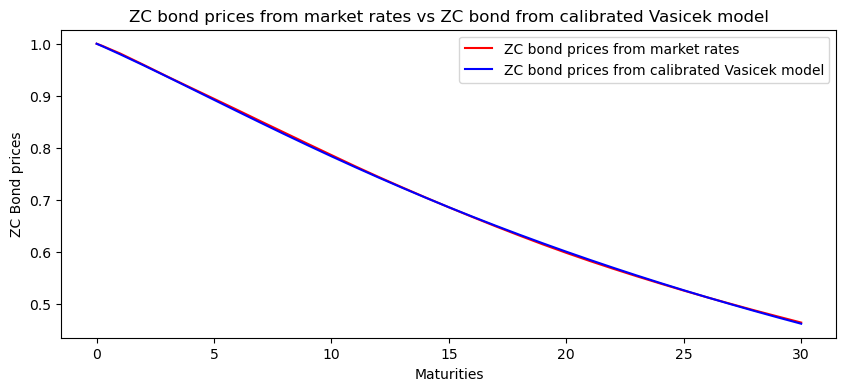

In [402]:
t, T = 0, 10

ZC_Market_Vasicek_calibrated = ZCCurve[['Maturity (in years)', 'ZC values']].copy()
ZC_Market_Vasicek_calibrated['VasicekZC'] = ZC_Market_Vasicek_calibrated['Maturity (in years)'].apply(lambda T : VasicekZCPrice(t, T, calibParam[0], calibParam[1], calibParam[2], calibParam[3]))

plt.figure(figsize=(10, 4))

plt.plot(ZC_Market_Vasicek_calibrated['Maturity (in years)'], ZC_Market_Vasicek_calibrated['ZC values'], color = 'r', label = 'ZC bond prices from market rates')
plt.plot(ZC_Market_Vasicek_calibrated['Maturity (in years)'], ZC_Market_Vasicek_calibrated['VasicekZC'], color = 'b', label = 'ZC bond prices from calibrated Vasicek model')
plt.xlabel("Maturities")
plt.ylabel("ZC Bond prices")
plt.title("ZC bond prices from market rates vs ZC bond from calibrated Vasicek model")
plt.legend()

Swaption pricing of characteristics :
- Notional $N = 1000000$
- Maturity of the swaption : $T_0$
- The underlying swap exchange a fixed rate $K$ against a floating rate at the same frequency with observation dates $T_0 ... T_{N-1}$ and payment dates $T_1 ... T_{N}$.

The payoff of this swaption is given by :
$$payoff = (SWAP_{T_0}(T_1 ... T_{N}) - K)_{+}$$
With : 
$$ SWAP_{T_0}(T_1 ... T_{N}) = N \times [1 - (\sum_{i=1}^{N} K \times ZC(t, T_i) +  ZC(t, T_N))] $$

At any time t before the swaption maturity (T0), the price of the swaption is 
provided by:

$$ Swaption_t = \mathbb{E}_{t}^{Q}[\exp(-\int_{t}^{T_0} r_u du) \times  (SWAP_{T_0}(T_1 ... T_{N}) - K)_{+}]$$
$$ Swaption_t = \mathbb{E}_{t}^{Q}[\exp(-\int_{t}^{T_0} r_u du) \times  (N \times [1 - (\sum_{i=1}^{N} K \times ZC(t, T_i) +  ZC(t, T_N))] - K)_{+}]$$

In [403]:
def VasicekPayerSwaptionPriceByMC(N, t, dates, K, a, theta, sigma, r, nbSimul, nbSteps):
    
    T = dates[0]
    dt = (T-t) / nbSteps
    sqrt_dt = sqrt(dt)
    std = sigma * sqrt( (1 - exp(-2*a*dt)) / (2*a) )
    result = 0
    
    for i in range(nbSimul):
        
        spotRate = r
        integralSpotRate = 0
        
        for j in range(nbSteps):
            spotRate = spotRate * exp(-a*dt) + theta * (1 - exp(-a*dt)) + std * gauss(0.0,1.0)
            integralSpotRate += spotRate
        integralSpotRate *= dt

        n = ZCCurve[ZCCurve['Maturity (in years)'] == T].index[0]  # the index of the maturity
        swapValue = SwapPrice(N, T, K, n)
        
        result += exp(-integralSpotRate) * max(swapValue,0)
    
    result /= nbSimul
    return result

In [404]:
t, dates = 0, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
K = 0.01
a , theta, sigma, r = calibParam[0], calibParam[1], calibParam[2], calibParam[3]

nbSimul, nbSteps = 10000, 100

print('The swaption price is : ', VasicekPayerSwaptionPriceByMC(N, t, dates, K , a, theta, sigma, r, nbSimul, nbSteps))

The swaption price is :  98892.3799593199
